1. Get a set of ImageNet pretrained weights for CSPDarknet53 from the Darknet GitHub repository

In [1]:
# !wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/csdarknet53-omega_final.weights

2. Add a method to load the pretrained weights into the backbone portion of your PyTorch YOLOv4 model

In [2]:
# !wget https://raw.githubusercontent.com/AlexeyAB/darknet/master/cfg/csdarknet53-omega.cfg
# !mkdir cfg
# !mv csdarknet53-omega.cfg cfg/

# !wget https://raw.githubusercontent.com/AlexeyAB/darknet/master/cfg/yolov4.cfg
# !mv yolov4.cfg cfg/

In [3]:

blocks = darknet.parse_cfg("cfg/csdarknet53-omega.cfg")
print(darknet.create_modules(blocks))

NameError: name 'darknet' is not defined

In [1]:
from util import *
from myDarknet import MyDarknet
import darknet
model = MyDarknet("cfg/yolov4.cfg")
model.load_weights("csdarknet53-omega_final.weights", backbone=True)

3. Implement a basic <code>train_yolo</code> function similar to the <code>train_model</code> function you developed in previous labs for classifiers that 

- preprocesses the input with basic augmentation transformations, converts the anchor-relative outputs to bounding box coordinates

- computes MSE loss for the bounding box coordinates, backpropagates the loss, and takes a step for the optimizer. 

- Use the recommended IoU thresholds to determine which predicted bounding boxes to include in the loss. You will find many examples of how to do this online

Ref1: https://github.com/Deeplodocus/COCO-with-YOLO

In [2]:
import json

with open('COCO/annotations/instances_val2017.json') as json_file:
    anno = json.load(json_file)
# anno.keys()
# dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

print(anno['images'][0])

print(anno['annotations'][0])

print(anno['categories'][0])

{'license': 4, 'file_name': '000000397133.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000397133.jpg', 'height': 427, 'width': 640, 'date_captured': '2013-11-14 17:02:52', 'flickr_url': 'http://farm7.staticflickr.com/6116/6255196340_da26cf2c9e_z.jpg', 'id': 397133}
{'segmentation': [[510.66, 423.01, 511.72, 420.03, 510.45, 416.0, 510.34, 413.02, 510.77, 410.26, 510.77, 407.5, 510.34, 405.16, 511.51, 402.83, 511.41, 400.49, 510.24, 398.16, 509.39, 397.31, 504.61, 399.22, 502.17, 399.64, 500.89, 401.66, 500.47, 402.08, 499.09, 401.87, 495.79, 401.98, 490.59, 401.77, 488.79, 401.77, 485.39, 398.58, 483.9, 397.31, 481.56, 396.35, 478.48, 395.93, 476.68, 396.03, 475.4, 396.77, 473.92, 398.79, 473.28, 399.96, 473.49, 401.87, 474.56, 403.47, 473.07, 405.59, 473.39, 407.71, 476.68, 409.41, 479.23, 409.73, 481.56, 410.69, 480.4, 411.85, 481.35, 414.93, 479.86, 418.65, 477.32, 420.03, 476.04, 422.58, 479.02, 422.58, 480.29, 423.01, 483.79, 419.93, 486.66, 416.21, 490.06, 415.57, 4

In [3]:
import torch
import torchvision
from torchvision import datasets, models, transforms
class myCocoDetection(datasets.CocoDetection):
    def __getitem__(self, index):
        from PIL import Image
        import os
        import os.path
        import numpy as np
        """
        Args:
            index (int): Index

        Returns:
            tuple: Tuple (image, target). target is the object returned by ``coco.loadAnns``.
        """
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        target = coco.loadAnns(ann_ids)
        path = coco.loadImgs(img_id)[0]['file_name']

        img = Image.open(os.path.join(self.root, path)).convert('RGB')
        img = np.array(img)

        category_ids = [obj['category_id'] for obj in target]
        bboxes = [obj['bbox'] for obj in target]

        import albumentations as A
        transform = A.Compose([
            A.SmallestMaxSize(256),
            A.CenterCrop(width=224, height=224),
            ], 
            bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']),
        )

        # bboxes = [obj['bbox'] for obj in target]
        # category_ids = [obj['category_id'] for obj in target]
        transformed = transform(image=img, bboxes=bboxes, category_ids=category_ids)
        img = transformed['image']
        bboxes = torch.Tensor(transformed['bboxes'])
        cat_ids = torch.Tensor(transformed['category_ids'])
        labels, bboxes = self.__create_label(bboxes, cat_ids.type(torch.IntTensor))

        return img, labels, bboxes

    def __create_label(self, bboxes, class_inds):
        """
        Label assignment. For a single picture all GT box bboxes are assigned anchor.
        1、Select a bbox in order, convert its coordinates("xyxy") to "xywh"; and scale bbox'
           xywh by the strides.
        2、Calculate the iou between the each detection layer'anchors and the bbox in turn, and select the largest
            anchor to predict the bbox.If the ious of all detection layers are smaller than 0.3, select the largest
            of all detection layers' anchors to predict the bbox.
        Note :
        1、The same GT may be assigned to multiple anchors. And the anchors may be on the same or different layer.
        2、The total number of bboxes may be more than it is, because the same GT may be assigned to multiple layers
        of detection.
        """
        ANCHORS = [
            [[12, 16], [19, 36], [40, 28]],
            [[36, 75], [76, 55], [72, 146]],
            [[142, 110], [192, 243], [459, 401]]
        ]

        STRIDES = [8, 16, 32]

        IP_SIZE = 224
        NUM_ANCHORS = 3
        NUM_CLASSES = 80
        import json
        with open('../coco_cats.json') as js:
            data = json.load(js)["categories"]

        cats_dict = {}
        for i in range(0, 80):
            cats_dict[str(data[i]['id'])] = i
        # print("Class indices: ", class_inds)
        bboxes = np.array(bboxes)
        class_inds = np.array(class_inds)
        anchors = ANCHORS # all the anchors
        strides = np.array(STRIDES) # list of strides
        train_output_size = IP_SIZE / strides # image with different scales
        anchors_per_scale = NUM_ANCHORS # anchor per scale

        # print(train_output_size)

        label = [
            np.zeros(
                (
                    int(train_output_size[i]),
                    int(train_output_size[i]),
                    anchors_per_scale,
                    5 + NUM_CLASSES,
                )
            )
            for i in range(3)
        ]
        # for i in range(3):
            # label[i][..., 5] = 1.0

        # 150 bounding box ground truths per scale
        bboxes_xywh = [
            np.zeros((150, 4)) for _ in range(3)
        ]  # Darknet the max_num is 30
        bbox_count = np.zeros((3,))

        for i in range(len(bboxes)):
            bbox_coor = bboxes[i][:4]
            bbox_class_ind = cats_dict[str(class_inds[i])]
            # bbox_mix = bboxes[i][5]

            # onehot
            one_hot = np.zeros(NUM_CLASSES, dtype=np.float32)
            one_hot[bbox_class_ind] = 1.0
            # one_hot_smooth = dataAug.LabelSmooth()(one_hot, self.num_classes)

            # convert "xyxy" to "xywh"
            bbox_xywh = np.concatenate(
                [
                    (0.5 * bbox_coor[2:] + bbox_coor[:2]) ,
                    bbox_coor[2:],
                ],
                axis=-1,
            )
            # print("bbox_xywh: ", bbox_xywh)
            
            bbox_xywh_scaled = (
                1.0 * bbox_xywh[np.newaxis, :] / strides[:, np.newaxis]
            )

            # print("bbox_xywhscaled: ", bbox_xywh_scaled)

            iou = []
            exist_positive = False
            for i in range(3):
                anchors_xywh = np.zeros((anchors_per_scale, 4))
                anchors_xywh[:, 0:2] = (
                    np.floor(bbox_xywh_scaled[i, 0:2]).astype(np.int32) + 0.5
                )  # 0.5 for compensation

                # assign all anchors 
                anchors_xywh[:, 2:4] = anchors[i]

                iou_scale = iou_xywh_numpy(
                    bbox_xywh_scaled[i][np.newaxis, :], anchors_xywh
                )
                iou.append(iou_scale)
                iou_mask = iou_scale > 0.3

                if np.any(iou_mask):
                    xind, yind = np.floor(bbox_xywh_scaled[i, 0:2]).astype(
                        np.int32
                    )

                    # Bug : 当多个bbox对应同一个anchor时，默认将该anchor分配给最后一个bbox
                    label[i][yind, xind, iou_mask, 0:4] = bbox_xywh * strides[i]
                    label[i][yind, xind, iou_mask, 4:5] = 1.0
                    label[i][yind, xind, iou_mask, 5:] = one_hot

                    bbox_ind = int(bbox_count[i] % 150)  # BUG : 150为一个先验值,内存消耗大
                    bboxes_xywh[i][bbox_ind, :4] = bbox_xywh * strides[i]
                    bbox_count[i] += 1

                    exist_positive = True

            if not exist_positive:
                # check if a ground truth bb have the best anchor with any scale
                best_anchor_ind = np.argmax(np.array(iou).reshape(-1), axis=-1)
                best_detect = int(best_anchor_ind / anchors_per_scale)
                best_anchor = int(best_anchor_ind % anchors_per_scale)

                xind, yind = np.floor(
                    bbox_xywh_scaled[best_detect, 0:2]
                ).astype(np.int32)

                label[best_detect][yind, xind, best_anchor, 0:4] = bbox_xywh * strides[best_detect]
                label[best_detect][yind, xind, best_anchor, 4:5] = 1.0
                # label[best_detect][yind, xind, best_anchor, 5:6] = bbox_mix
                label[best_detect][yind, xind, best_anchor, 5:] = one_hot 

                bbox_ind = int(bbox_count[best_detect] % 150)
                bboxes_xywh[best_detect][bbox_ind, :4] = bbox_xywh * strides[best_detect]
                bbox_count[best_detect] += 1

        flatten_size_s = int(train_output_size[2]) * int(train_output_size[2]) * anchors_per_scale
        flatten_size_m = int(train_output_size[1]) * int(train_output_size[1]) * anchors_per_scale
        flatten_size_l = int(train_output_size[0]) * int(train_output_size[0]) * anchors_per_scale

        label_s = torch.Tensor(label[2]).view(1, flatten_size_s, 5 + NUM_CLASSES).squeeze(0)
        label_m = torch.Tensor(label[1]).view(1, flatten_size_m, 5 + NUM_CLASSES).squeeze(0)
        label_l = torch.Tensor(label[0]).view(1, flatten_size_l, 5 + NUM_CLASSES).squeeze(0)

        bboxes_s = torch.Tensor(bboxes_xywh[2])
        bboxes_m = torch.Tensor(bboxes_xywh[1])
        bboxes_l = torch.Tensor(bboxes_xywh[0])

        # label_sbbox, label_mbbox, label_lbbox = label
        sbboxes, mbboxes, lbboxes = bboxes_xywh
        # print("label")
        labels = torch.cat([label_l, label_m, label_s], 0)
        bboxes = torch.cat([bboxes_l, bboxes_m, bboxes_s], 0)
        return labels, bboxes


def iou_xywh_numpy(boxes1, boxes2):
    """
    :param boxes1: boxes1和boxes2的shape可以不相同，但是需要满足广播机制
    :param boxes2: 且需要保证最后一维为坐标维，以及坐标的存储结构为(x,y,w,h)，其中(x,y)是bbox的中心坐标
    :return: 返回boxes1和boxes2的IOU，IOU的shape为boxes1和boxes2广播后的shape[:-1]
    """
    boxes1 = np.array(boxes1)
    boxes2 = np.array(boxes2)
    # print(boxes1, boxes2)

    boxes1_area = boxes1[..., 2] * boxes1[..., 3]
    boxes2_area = boxes2[..., 2] * boxes2[..., 3]

    # 分别计算出boxes1和boxes2的左上角坐标、右下角坐标
    # 存储结构为(xmin, ymin, xmax, ymax)，其中(xmin,ymin)是bbox的左上角坐标，(xmax,ymax)是bbox的右下角坐标
    boxes1 = np.concatenate([boxes1[..., :2] - boxes1[..., 2:] * 0.5,
                                boxes1[..., :2] + boxes1[..., 2:] * 0.5], axis=-1)
    boxes2 = np.concatenate([boxes2[..., :2] - boxes2[..., 2:] * 0.5,
                                boxes2[..., :2] + boxes2[..., 2:] * 0.5], axis=-1)

    # 计算出boxes1与boxes1相交部分的左上角坐标、右下角坐标
    left_up = np.maximum(boxes1[..., :2], boxes2[..., :2])
    right_down = np.minimum(boxes1[..., 2:], boxes2[..., 2:])

    # 因为两个boxes没有交集时，(right_down - left_up) < 0，所以maximum可以保证当两个boxes没有交集时，它们之间的iou为0
    inter_section = np.maximum(right_down - left_up, 0.0)
    inter_area = inter_section[..., 0] * inter_section[..., 1]
    union_area = boxes1_area + boxes2_area - inter_area
    IOU = 1.0 * inter_area / union_area
    return IOU


In [4]:
root = "COCO/val2017"
annFile = 'COCO/annotations/instances_val2017.json'

full_dataset = myCocoDetection(root=root, annFile=annFile)
# loading annotations into memory...
# Done (t=0.50s)
# creating index...
# index created!
# Dataset CocoDetection
#     Number of datapoints: 5000
#     Root location: COCO/val2017
BATCH_SIZE = 4
NUM_WORKERS = 0


train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [4000, 1000])
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=BATCH_SIZE, shuffle=True , num_workers=NUM_WORKERS, collate_fn=collate_fn)
val_dataloader  = torch.utils.data.DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.49s)
creating index...
index created!


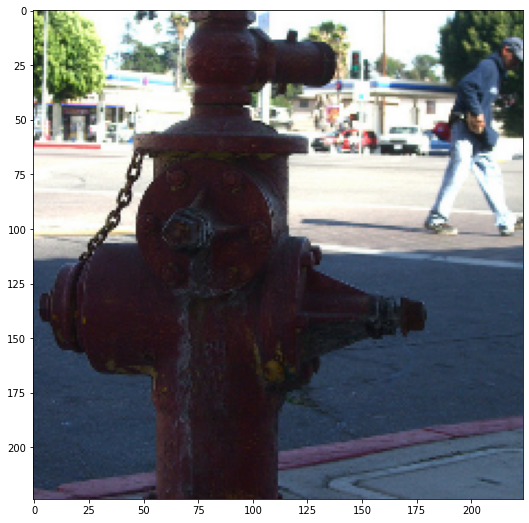

In [141]:
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches
# import numpy as np
# # get some random training images
# dataiter = iter(train_dataloader)
# # print(dataiter.next())

# images, labels, boxes = dataiter.next()

# toshow = torchvision.utils.make_grid(np.transpose(images, (0,3,1,2)))
# toshow = toshow / 2 + 0.5     # unnormalize
# npimg = toshow.numpy()

# fig, ax = plt.subplots(figsize=(16,9))

# ax.imshow(np.transpose(images, (0,1,2,3) )[0] )

# print(boxes)
# print(labels.shape)
# ax.imshow(images)
# print(labels[1]['bbox'])
# # dict_keys(['segmentation', 'area', 'iscrowd', 'image_id', 'bbox', 'category_id', 'id'])
# for index, img in enumerate(images):

#     for i,l in enumerate(labels):
#         x,y,w,h = labels[i]['bbox']
#         x,y,w,h = float(x),float(y),float(w),float(h)
#         # print(x,y,w,h)
#         rect = patches.Rectangle(xy=(x,y),width=w,height=h, linewidth=2, edgecolor='g', facecolor='none')
#         ax.add_patch(rect)
plt.show()
# print(labels, classes[labels])

In [5]:
import torch.optim as optim
# Set device to GPU or CPU
gpu = "0"
device = torch.device("cuda:{}".format(gpu) if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

criterion = nn.CrossEntropyLoss()
params_to_update = model.parameters()
optimizer = optim.Adam(params_to_update, lr=0.001)

cuda:0


In [8]:
import math
def CIOU_xywh_torch(boxes1,boxes2):
    '''
    cal CIOU of two boxes or batch boxes
    :param boxes1:[xmin,ymin,xmax,ymax] or
                [[xmin,ymin,xmax,ymax],[xmin,ymin,xmax,ymax],...]
    :param boxes2:[xmin,ymin,xmax,ymax]
    :return:
    '''
    # cx cy w h->xyxy
    boxes1 = torch.cat([boxes1[..., :2] - boxes1[..., 2:] * 0.5,
                        boxes1[..., :2] + boxes1[..., 2:] * 0.5], dim=-1)
    boxes2 = torch.cat([boxes2[..., :2] - boxes2[..., 2:] * 0.5,
                        boxes2[..., :2] + boxes2[..., 2:] * 0.5], dim=-1)

    boxes1 = torch.cat([torch.min(boxes1[..., :2], boxes1[..., 2:]),
                        torch.max(boxes1[..., :2], boxes1[..., 2:])], dim=-1)
    boxes2 = torch.cat([torch.min(boxes2[..., :2], boxes2[..., 2:]),
                        torch.max(boxes2[..., :2], boxes2[..., 2:])], dim=-1)

    # (x2 minus x1 = width)  * (y2 - y1 = height)
    boxes1_area = (boxes1[..., 2] - boxes1[..., 0]) * (boxes1[..., 3] - boxes1[..., 1])
    boxes2_area = (boxes2[..., 2] - boxes2[..., 0]) * (boxes2[..., 3] - boxes2[..., 1])

    # upper left of the intersection region (x,y)
    inter_left_up = torch.max(boxes1[..., :2], boxes2[..., :2])

    # bottom right of the intersection region (x,y)
    inter_right_down = torch.min(boxes1[..., 2:], boxes2[..., 2:])

    # if there is overlapping we will get (w,h) else set to (0,0) because it could be negative if no overlapping
    inter_section = torch.max(inter_right_down - inter_left_up, torch.zeros_like(inter_right_down))
    inter_area = inter_section[..., 0] * inter_section[..., 1]
    union_area = boxes1_area + boxes2_area - inter_area
    ious = 1.0 * inter_area / union_area

    # cal outer boxes
    outer_left_up = torch.min(boxes1[..., :2], boxes2[..., :2])
    outer_right_down = torch.max(boxes1[..., 2:], boxes2[..., 2:])
    outer = torch.max(outer_right_down - outer_left_up, torch.zeros_like(inter_right_down))
    outer_diagonal_line = torch.pow(outer[..., 0], 2) + torch.pow(outer[..., 1], 2)

    # cal center distance
    # center x center y
    boxes1_center = (boxes1[..., :2] +  boxes1[...,2:]) * 0.5
    boxes2_center = (boxes2[..., :2] +  boxes2[...,2:]) * 0.5

    # euclidean distance
    # x1-x2 square 
    center_dis = torch.pow(boxes1_center[...,0]-boxes2_center[...,0], 2) +\
                 torch.pow(boxes1_center[...,1]-boxes2_center[...,1], 2)

    # cal penalty term
    # cal width,height
    boxes1_size = torch.max(boxes1[..., 2:] - boxes1[..., :2], torch.zeros_like(inter_right_down))
    boxes2_size = torch.max(boxes2[..., 2:] - boxes2[..., :2], torch.zeros_like(inter_right_down))
    v = (4 / (math.pi ** 2)) * torch.pow(
            torch.atan((boxes1_size[...,0]/torch.clamp(boxes1_size[...,1],min = 1e-6))) -
            torch.atan((boxes2_size[..., 0] / torch.clamp(boxes2_size[..., 1],min = 1e-6))), 2)

    alpha = v / (1-ious+v)

    #cal ciou
    cious = ious - (center_dis / outer_diagonal_line + alpha*v)

    return cious

def calculate_APs(iou_threshold, batches, targets):
    from pycocotools.coco import COCO
    # root = "COCO/val2017"
    # annFile = 'COCO/annotations/instances_val2017.json'
    coco = COCO('COCO/annotations/instances_val2017.json')
    ids = list(sorted(coco.imgs.keys()))

    # img_id = ids[index]
    # ann_ids = coco.getAnnIds(imgIds=img_id)
    # ids = list(range(0,91))
    target = coco.anns
    # idx = list(target.keys())
    print(len(target))
    print(type(target))
    number_of_classes = 80
    # target = target
    for index in ids:
        print(target[index])
    # print(len(idx))
    # print(ids)
    # self.target = target
    # for i in range(0, 500):
    #     img_id = idx[i]
    #     tar = target[img_id]
    #     print(tar)
    # path = coco.loadImgs(img_id)[0]['file_name']
    
    APs = {}
    recalls = {}
    precisions = {}
    # 80 classes
    # print(target)
    # for i in range(0, 80):

In [10]:
for e in range(0, 1000):
    running_loss = 0.0
    for inputs, labels, bboxes in train_dataloader:
        inputs = torch.from_numpy(np.array(inputs)).squeeze(1).permute(0,3,1,2).float()
        inputs = inputs.to(device)
        # print(type(labels[:,:,0]))
        labels = torch.stack(labels).to(device)
        
        running_corrects = 0

        # zero the parameter gradients
        # it uses for update training weights
        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            outputs = model(inputs, True)
            # pred_xy = outputs[..., :2] / 224
            # pred_wh = torch.sqrt(outputs[..., 2:4] / 224)

            pred_xywh = outputs[..., 0:4] / 224
            # pred_xywh = torch.cat([pred_xy, pred_wh], dim=-1)
            pred_conf = outputs[..., 4:5]
            pred_cls = outputs[..., 5:]


            # label_xy = labels[..., :2] / 224
            # label_wh = torch.sqrt(labels[..., 2:4] / 224)

            label_xywh = labels[..., :4] / 224

            # label_xywh = torch.cat([label_xy, label_wh], dim=-1)
            label_obj_mask = labels[..., 4:5]
            label_noobj_mask = (1.0 - label_obj_mask)  # * (
                # iou_max < self.__iou_threshold_loss
            # ).float()
            lambda_coord = 0.001
            lambda_noobj = 0.05
            label_cls = labels[..., 5:]
            loss = nn.MSELoss()
            loss_bce = nn.BCELoss()

            # ciou = CIOU_xywh_torch(p_d_xywh, label_xywh).unsqueeze(-1)

            loss_coord = lambda_coord * label_obj_mask * loss(input=pred_xywh, target=label_xywh)
            loss_conf = (label_obj_mask * loss_bce(input=pred_conf, target=label_obj_mask)) + \
                        (lambda_noobj * label_noobj_mask * loss_bce(input=pred_conf, target=label_obj_mask))
            loss_cls = label_obj_mask * loss_bce(input=pred_cls, target=label_cls)

            loss_coord = torch.sum(loss_coord)
            loss_conf = torch.sum(loss_conf)
            loss_cls = torch.sum(loss_cls)

            # print(pred_xywh.shape, label_xywh.shape)

            ciou = CIOU_xywh_torch(pred_xywh, label_xywh)
            # print(ciou.shape)
            ciou = ciou.unsqueeze(-1)
            # print(ciou.shape)
            # print(label_obj_mask.shape)
            loss_ciou = torch.sum(label_obj_mask * (1.0 - ciou))
            # print(loss_coord)
            loss =  loss_ciou +  loss_conf + loss_cls
            loss.backward()
            optimizer.step()
            # statistics
            running_loss += loss.item() * inputs.size(0)
            # print('Running loss')
            # print(loss_coord, loss_conf, loss_cls)
    
    epoch_loss = running_loss / 750
    print(epoch_loss)
    print('Epoch')

    # print(calculate_APs(0.5, None, None))
    # break
    # print(x.shape)
    # print(y.shape)
    # print(w.shape)
    # print(h.shape)
    # print(obj.shape)
    # print(cls.shape)
    # break

189.93379638163248
Epoch
189.41411167907714
Epoch
189.1372488861084
Epoch
188.7356580327352
Epoch
190.92947319030762
Epoch
189.1581682917277
Epoch
189.2966618754069
Epoch
188.85461089579263
Epoch
188.25761431884766
Epoch
188.30148197937012
Epoch
188.2817258834839
Epoch
187.6737065785726
Epoch
186.7383384246826
Epoch
186.1316461435954
Epoch
185.80190116882324
Epoch
185.7278603668213
Epoch
185.4306427866618
Epoch
185.18206003570558
Epoch
185.0051978225708
Epoch
184.7988573506673
Epoch
184.73620741526287
Epoch
184.598572362264
Epoch
184.3989153137207
Epoch
184.2619078572591
Epoch
184.14537154897053
Epoch
184.0755648651123
Epoch
183.84709812927247
Epoch
183.70032418314617
Epoch
183.51979211425783
Epoch
183.47742815144858
Epoch
183.23646695454914
Epoch
182.95384554290771
Epoch
182.7338719024658
Epoch
182.54506600697835
Epoch
182.29108727010092
Epoch
182.0195166422526
Epoch
181.83487119293213
Epoch
181.46037130737304
Epoch
181.2267195714315
Epoch
181.01546776326498
Epoch
